In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from os import path,listdir
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import json 
import itertools

import networkx as nx

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import MultiTaskLasso,RidgeClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score,  multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc, make_scorer
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from regressors import stats as regstats
import statsmodels.api as sm

pd.options.display.max_columns = 500
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision_micro': make_scorer(precision_score, average='micro'),
           'recall_micro': make_scorer(recall_score, average='micro'),
           'f1_micro': make_scorer(f1_score, average='micro'),
           }

def hdmatrix(a,b,columns=None,title='',pdf=None,figsize=(10,10),hue_map=None):
    sns.set_style('white')
    # A = pd.DataFrame(A)
    # B = pd.DataFrame(B)
    A = a.copy()
    B = b.copy()
    XNOR = np.logical_not(np.logical_xor(A, B)).astype(int)    
    XNOR = pd.DataFrame(XNOR)    
    if columns is not None:
        XNOR.columns = columns
    _unique = np.unique(XNOR)
    if len(_unique)==2:
        cmap = ListedColormap(['#F08080', 'darkgreen'])
    elif _unique[0]==0:
        cmap = ListedColormap(['#F08080'])
    else:
        cmap = ListedColormap(['darkgreen'])
        
    L = A.shape[0]*A.shape[1]
    HAMMING = XNOR.values.sum()/L
    JACCARD = np.logical_and(A, B).astype(int).values.sum()/np.logical_or(A, B).astype(int).values.sum()
    F1=f1_score(A,B,average='micro')
    

    XNOR['all_ones'] = XNOR.eq(1).all(axis=1)
    ### TODO: fix extreme case: all correct or all incorrect.    
    plt.close('all')
    g = sns.clustermap(XNOR.drop('all_ones', axis=1), row_cluster=True, col_cluster=True,figsize=figsize)
    plt.close('all')
    row_order = g.dendrogram_row.reordered_ind
    df_reordered = XNOR.iloc[row_order].sort_values('all_ones', ascending=False).drop('all_ones', axis=1)
    all_ones = XNOR[XNOR['all_ones']]
    ACC = (len(all_ones) / len(XNOR))
    if hue_map is not None:
        df_reordered.columns = [hue_map.get(x,x.title()) for x in df_reordered.columns]
    cluster = sns.clustermap(df_reordered, row_cluster=False, col_cluster=True,
                             cmap=cmap,                             
                             dendrogram_ratio=(0.15, 0.01), 
                             figsize=figsize,
                             xticklabels=True, yticklabels=False,)
    cluster.ax_row_dendrogram.set_visible(False)
    cluster.ax_col_dendrogram.set_visible(False)
    
    colorbar = cluster.ax_heatmap.collections[0].colorbar
    if len(_unique)==2:
        colorbar.set_ticks([0.25, 0.75])
        colorbar.set_ticklabels(['False', 'True'])
        y_cbar_text = -.1
    else:
        colorbar.set_ticks([1])
        colorbar.set_ticklabels([('False' if _unique[0]==0 else 'True')])
        y_cbar_text = .88
    cluster.ax_cbar.text(0,y_cbar_text,'F1=%.2f\nACC=%.2f\nHD=%.2f\nJ=%.2f'%(F1,ACC,HAMMING,JACCARD),va='top')
    cluster.tick_params(axis='x', which='major', labelsize=10, 
                            labelbottom = False, bottom=False, top = True, labeltop=True)
    plt.setp(cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=20, va='bottom',ha='left')
    plt.suptitle(title,y=1.1)
    rect = plt.Rectangle((0, 0), cluster.ax_heatmap.get_xlim()[1]-.01, len(all_ones), lw=2, edgecolor='darkblue', facecolor='none')
    cluster.ax_heatmap.add_patch(rect)
    # plt.tight_layout()
    if pdf is not None:
        pdf.savefig(cluster.fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def feature_importance(X_train,y_train,clf,pdf=None,title='',figsize=(10,5)):
    sns.set_style('white')
    n_features = X_train.shape[1]
    _labels = list(y_train.columns)
    n_labels = len(_labels)
    feature_importances = np.zeros((n_labels, n_features))
    for i, label in enumerate(_labels):
        estimator = clf.estimators_[i]
        feature_importances[i] = estimator.feature_importances_

    zz = pd.DataFrame(feature_importances)
    zz.columns = [x.replace('ft_','') for x in X_train.columns]
    zz['label'] = [x.replace('LABEL_','').replace('GROUP_','') for x in _labels]
    zz.set_index('label',inplace=True)
    _ = zz.sum().to_dict()
    zz = zz[sorted(zz.columns,key=lambda x:-_[x])]
    fig,ax = plt.subplots(figsize=figsize)            
    sns.heatmap(zz,cmap='viridis',ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
    ax.set_ylabel('')
    plt.suptitle(title,y=1.18,fontsize=14)
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_roc(X_test,y_test,clf,pdf=None,title='',figsize=(6, 6),hue_order=None,hue_map=None):
    sns.set_style('whitegrid')
    _labels = list(y_test.columns)
    y_pred_prob = clf.predict_proba(X_test)
    y_test_concat = y_test.values
    y_pred_concat = np.concatenate(y_pred_prob, axis=0)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred_prob[i][:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig,ax = plt.subplots(figsize=figsize)
    cmap = mpl.cm.get_cmap('tab20')
    label_colors = {x:cmap(idx%20) for idx,x in enumerate(_labels)}

    if hue_order is not None:
        iterlist = hue_order
    else:
        iterlist = range(len(_labels))
    for i in iterlist:
        _label = _labels[i].replace('LABEL_','').replace('GROUP_','')
        if hue_map is not None:
            _label = hue_map.get(_label,_label.title())
        plt.plot(fpr[i], tpr[i], lw=2,color=label_colors[_labels[i]],
                 label='{0} (AUC = {1:0.2f})'.format(_label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_confusion_matrices(y_test,y_pred,title='',pdf=None,hue_order=None,hue_map=None):
    sns.set_style('white')
    _labels = list(y_test.columns)
    cm = multilabel_confusion_matrix(y_test, y_pred)
    ncols = 4
    nrows = int(np.ceil(len(cm)/ncols))
    blank = (ncols*nrows)-len(cm)
    fig,axs =plt.subplots(figsize=(11,2.5*nrows),ncols=ncols,nrows=nrows)
    axs = axs.flatten()
    if hue_order is not None:
        iterlist = hue_order
    else:
        iterlist = list(range(len(cm)))
    for IDX,i in enumerate(iterlist):
        ax = axs[IDX]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i], display_labels=[0,1])
        disp.plot(cmap='Blues',ax=ax)
        _title = _labels[i].replace('LABEL_','').replace('GROUP_','')
        if hue_map is not None:
            _title = hue_map.get(_title,_title.title())
        ax.set_title(f'{_title}',fontsize=10,fontweight='bold')
        if IDX%ncols!=0:
            ax.set_ylabel('')        
            ax.set_yticks([])
        if blank>0 and (IDX//ncols)==(nrows-2):
            if (ncols-(IDX%ncols))<=blank:
                continue
        if (IDX//ncols)!=(nrows-1):
            ax.set_xlabel('')        
            ax.set_xticks([])
    for i in range(len(cm),(ncols*nrows)):
        axs[i].axis('off')

    plt.suptitle(title,y=0.98,fontsize=14)
    # plt.subplots_adjust(wspace=0.15,hspace=0.32)
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
def plot_groups_diagram(groups,cols_labels_full,cols_labels,pdf=None,figsize=(12,10),dpi=75,X_RECT1 = 1150, X_RECT2 = 1320):
    sns.set_style('white')
    # Define the graph
    not_included = [x.replace('LABEL_','') for x in sorted(set(cols_labels_full)-set(cols_labels))]

    G = nx.DiGraph()
    # Add nodes
    G.add_node("Groups")
    for k,v in groups.items():
        k2 = k.replace('GROUP_','')
        G.add_edge('Groups',k2)
        for u in  v:
            u2 = u.replace('LABEL_','')
            if k2==u2:
                u2=u2+'.'
            G.add_edge(k2,u2)
    # if len(not_included)>0:
    #     G.add_edge('Groups','Not included:')

    # Plot the graph
    fig,ax = plt.subplots(figsize=figsize,dpi=dpi)
    # pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos, linewidths=1, node_size=0, node_color="white", 
                           edgecolors="none",margins=(0.02,.2),ax=ax)
    nx.draw_networkx_edges(G, pos, width=1, edge_color="black", arrowstyle="->",ax=ax,min_source_margin=35,min_target_margin=35)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="normal", ax=ax,verticalalignment='center')

#     _patches = []
#     ax.text(0,pos[k2][1]+10,'Groups',ha='left',va='bottom',color='black',weight='bold')
#     rect = patches.Rectangle((0, pos[k2][1]-5), X_RECT1, 12, linewidth=1, edgecolor='none', facecolor='red',alpha=0.5)
#     _patches.append(rect)

#     ax.text(0,pos[u2][1]+10,'Bacteria',ha='left',va='bottom',color='black',weight='bold')
#     rect = patches.Rectangle((0, pos[u2][1]-5), X_RECT2, 12, linewidth=1, edgecolor='none', facecolor='darkorange',alpha=0.5)
#     _patches.append(rect)

#     for p in _patches:
#         ax.add_patch(p)

#     if len(not_included)>0:
#         ax.text(pos['Not included:'][0],pos['Not included:'][1]-5,'\n'.join(not_included),
#                 fontsize=8.5,ha='center',va='top',color='black')

    plt.axis("off")
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
    
def feature_importance2(X_train,y_train,X_test,y_test,y_pred,clf,pdf=None,title='',figsize=(10,5),hue_map=None):
    sns.set_style('white')
    n_features = X_train.shape[1]
    _labels = list(y_train.columns)
    n_labels = len(_labels)
    feature_importances = np.zeros((n_labels, n_features))    
    for i, label in enumerate(_labels):
        estimator = clf.estimators_[i]
        feature_importances[i] = estimator.feature_importances_
        
    
    y_pred_prob = clf.predict_proba(X_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i,label in enumerate(_labels):
        fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred_prob[i][:, 1])
        roc_auc[label.replace('LABEL_','').replace('GROUP_','')] = np.round(auc(fpr[i], tpr[i]),2)    

    zz = pd.DataFrame(feature_importances)
    zz.columns = [x.replace('ft_','') for x in X_train.columns]
    zz['label'] = [x.replace('LABEL_','').replace('GROUP_','') for x in _labels]
    zz['auc'] = zz['label'].map(roc_auc)
    if hue_map is None:
        zz['label'] = zz.apply(lambda x:"%s (AUC=%.2f)"%(x['label'],x['auc']),axis=1)
    else:
        zz['label'] = zz.apply(lambda x:"%s (AUC=%.2f)"%(hue_map.get(x['label'],x['label']),x['auc']),axis=1)
    zz.sort_values(by='auc',ascending=False,inplace=True)
    zz.pop('auc')
    zz.set_index('label',inplace=True)
    _ = zz.sum().to_dict()
    zz = zz[sorted(zz.columns,key=lambda x:-_[x])]
    ###TODO: REMOVE LATER
    zz = zz[list(zz.columns)[:40]]
    
    fig,ax = plt.subplots(figsize=figsize)
    if hue_map is not None:
        zz.columns = [hue_map.get(x,x.title()) for x in zz.columns]
    sns.heatmap(zz,cmap='viridis',ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
    ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
    ax.set_ylabel('')
    plt.suptitle(title,fontsize=14)
    plt.tight_layout()
    if pdf is not None:
        pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)
    plt.show()
    
    
def summary(clf, X, y, xlabels=None,display=False):
    """
    Output summary statistics for a fitted regression model.

    Parameters
    ----------
    clf : sklearn.linear_model
        A scikit-learn linear model classifier with a `predict()` method.
    X : numpy.ndarray
        Training data used to fit the classifier.
    y : numpy.ndarray
        Target training values, of shape = [n_samples].
    xlabels : list, tuple
        The labels for the predictors.
    """
    # Check and/or make xlabels
    ncols = X.shape[1]
    if xlabels is None:
        xlabels = np.array(
            ['x{0}'.format(i) for i in range(1, ncols + 1)], dtype='str')
    elif isinstance(xlabels, (tuple, list)):
        xlabels = np.array(xlabels, dtype='str')
    # Make sure dims of xlabels matches dims of X
    if xlabels.shape[0] != ncols:
        raise AssertionError(
            "Dimension of xlabels {0} does not match "
            "X {1}.".format(xlabels.shape, X.shape))
    # Create data frame of coefficient estimates and associated stats
    coef_df = pd.DataFrame(
        index=['_intercept'] + list(xlabels),
        columns=['Estimate', 'Std. Error', 't value', 'p value']
    )    
    try:
        coef_df['Estimate'] = np.concatenate(
            (np.round(np.array([clf.intercept_]), 6), 
             np.round((clf.coef_), 6)))
    except:
        coef_df['Estimate'] = np.concatenate(
            (
                np.round(np.array([clf.intercept_]), 6),
                np.round((clf.coef_), 6)
            ), axis = 1).T
    coef_df['Std. Error'] = np.round(regstats.coef_se(clf, X, y), 6)
    coef_df['t value'] = np.round(regstats.coef_tval(clf, X, y), 4)
    coef_df['p value'] = np.round(regstats.coef_pval(clf, X, y), 6)
    # Create data frame to summarize residuals
    resids = regstats.residuals(clf, X, y, r_type='raw')
    resids_df = pd.DataFrame({
        'Min': pd.Series(np.round(resids.min(), 4)),
        '1Q': pd.Series(np.round(np.percentile(resids, q=25), 4)),
        'Median': pd.Series(np.round(np.median(resids), 4)),
        '3Q': pd.Series(np.round(np.percentile(resids, q=75), 4)),
        'Max': pd.Series(np.round(resids.max(), 4)),
    }, columns=['Min', '1Q', 'Median', '3Q', 'Max'])
    # Output results
    if display:
        print("Residuals:")
        print(resids_df.to_string(index=False))
        print('\n')
        print('Coefficients:')
        print(coef_df.to_string(index=True))
        print('---')
        print('R-squared:  {0:.5f},    Adjusted R-squared:  {1:.5f}'.format(
            metrics.r2_score(y, clf.predict(X)), regstats.adj_r2_score(clf, X, y)))
        print('F-statistic: {0:.2f} on {1} features'.format(
            regstats.f_stat(clf, X, y), ncols))
    return coef_df

map_labels = {}
map_all = {'staphylococci':'$\it{Staphylococcus}$ spp.',
         'enterobacterales':'Enterobacterales',
         'enteros':'Enterobacterales',
         'fungi':'Fungi',
          'enterococci':'$\it{Enterococcus}$ spp.',
          'streptococci':'$\it{Streptococcus}$ spp.',
          'gram.neg':'Other Gram-negative bacteria',
          'anaerobic':'Anaerobic bacteria',
           'age':'Age',
           'duree':'Duration of surgery',
           'bmi':'BMI [kg/m²]',
           'surg':'Type of surgery',
           'asa':'ASA score',
           'class':'Wound contamination',
           'clindamycine':'Clindamycine',
           'cephalosporin.all':'Cephalosporine',
           'glycopeptide':'Glycopeptide',
           'quinolone':'Quinolone',
           'elective':'Elective procedure',
           'endo_2L':'Minimally invasive procedure',
           'nitroimidazole':'Nitroimidazole',
           'penicillin.all':'Penicilin',
           'carbapenem':'Carbapenem',
           'SAP.b':'SAP administered (yes / no)',
           'hosp_size':'Hospital size',
           'sex':'Sex',
           'other.SAP2':'Other SAP',
           'prev.hosp.b':'Hospitalization prior to surgery'}

# Variables

In [8]:
input_path = 'inputs'
output_path = 'outputs_september'
clean_train_csv = path.join(input_path,'scaled2.train.csv')
clean_test_csv = path.join(input_path,'scaled2.test.csv')

groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)
output_test_groups = path.join(output_path,'output_test_'+groups_name)

# Predict surgery with ridge regression

In [9]:
groups_name = 'groups9.csv'
groups_csv = path.join(input_path,groups_name)
df = pd.read_csv(clean_train_csv)    
dfT = pd.read_csv(clean_test_csv)

df['_id'] = range(len(df))
dfT['_id'] = range(len(dfT))

cols_ft = [x for x in df.columns if x.startswith('ft_') and not x.startswith('ft_surg')]
cols_labels = sorted([x for x in df.columns if x.startswith('ft_surg')])
print(cols_ft)
print(cols_labels)

print('Full training:',len(df))
df.dropna(inplace=True)
print('dropna training:',len(df))

print('Full test:',len(dfT))
dfT.dropna(inplace=True)
print('dropna test:',len(dfT))

X_surg_train = df[cols_ft]
y_surg = df[cols_labels]
X_surg_test = dfT[cols_ft]
y_test_surg = dfT[cols_labels]

['ft_age', 'ft_bmi', 'ft_duree', 'ft_asa_1', 'ft_asa_2', 'ft_asa_3', 'ft_asa_4', 'ft_asa_5', 'ft_class_Clean', 'ft_class_Clean-Contaminated', 'ft_class_Contaminated', 'ft_class_Dirty/Infected', 'ft_hosp_size_200-499', 'ft_hosp_size_500+', 'ft_hosp_size_<200', 'ft_carbapenem', 'ft_cephalosporin.all', 'ft_clindamycine', 'ft_elective', 'ft_endo_2L', 'ft_glycopeptide', 'ft_implant', 'ft_nitroimidazole', 'ft_other.SAP2', 'ft_penicillin.all', 'ft_prev.hosp.b', 'ft_quinolone', 'ft_SAP.b', 'ft_scoreT', 'ft_sex']
['ft_surg_Cholecystectomy', 'ft_surg_Colorectal surgery', 'ft_surg_Heart surgery', 'ft_surg_Hernia surgery', 'ft_surg_Hip replacement', 'ft_surg_Knee replacement', 'ft_surg_Spinal surgery']
Full training: 5239
dropna training: 5239
Full test: 1363
dropna test: 1363


In [10]:
HIGH_VIF = []
X_train2 = X_surg_train.drop(columns=HIGH_VIF)
X_test2 = X_surg_test.drop(columns=HIGH_VIF)
features = list(X_train2.columns)
labels_surg = list(y_surg.columns)

model = RidgeClassifier(alpha=1,random_state=42)
surg_classifier = MultiOutputClassifier(model).fit(X_train2, y_surg)

coefs_group = np.array([estimator.coef_ for estimator in surg_classifier.estimators_]).squeeze()
coef_df = []
for i,estimator in enumerate(coefs_group):
    for j,c in enumerate(estimator):
        coef_df.append(('Surgeries',labels_surg[i],features[j],c))
            
# #####################
R_surg = {}
namex='LinearRegression'
y_surg_pred = surg_classifier.predict(X_test2)

accuracy = accuracy_score(y_test_surg, y_surg_pred)
precision = precision_score(y_test_surg, y_surg_pred, average='micro')
recall = recall_score(y_test_surg, y_surg_pred, average='micro')
f1 = f1_score(y_test_surg, y_surg_pred, average='micro')
R_surg[namex] = {'accuracy':accuracy,
           'precision_micro':precision, 
           'recall_micro':recall, 
           'f1_micro':f1}

print('Surgery',R_surg)

Surgery {'LinearRegression': {'accuracy': 0.7446808510638298, 'precision_micro': 0.911190053285968, 'recall_micro': 0.7527512839325018, 'f1_micro': 0.8244274809160305}}


---
# Bootstrap

In [ ]:
n_iterations = 1000  # Number of bootstrap samples to create
r_surg = []
# Run bootstrap
for i in range(n_iterations):
    if i%10==0:
        print(i)
    X_surg_resample, y_surg_resample = resample(X_train2, y_surg)
    
    model = RidgeClassifier(alpha=1,random_state=42)
    surg_classifier2 = MultiOutputClassifier(model).fit(X_surg_resample, y_surg_resample)
    coefs_surg = np.array([estimator.coef_ for estimator in surg_classifier2.estimators_]).squeeze()    
    r_surg.append(coefs_surg)    

In [12]:
intervals = {}
for i in range(len(r_surg[0])):    
    coefficients = np.zeros((n_iterations, X_train2.shape[1]))
    for j in range(len(r_surg)):
        coefficients[j] = r_surg[j][i]
    # # Confidence intervals
    lower = np.percentile(coefficients, 2.5, axis=0)
    upper = np.percentile(coefficients, 97.5, axis=0)
    #_intercept fix
    lower = np.insert(lower,0,0)
    upper = np.insert(upper,0,0)
    intervals[labels_surg[i]] = {'lo':lower,'hi':upper}

In [13]:
rows = []
for i,e in enumerate(surg_classifier.estimators_):
    CC = summary(e, X_train2, y_surg.values[:,i],xlabels=list(X_train2.columns),display=False)
    CC['level']='surg'
    CC['name']=labels_surg[i]
    CC['lo'] = intervals[labels_surg[i]]['lo']
    CC['hi'] = intervals[labels_surg[i]]['hi']
    CC.drop(columns = ['Std. Error','t value'], inplace=True)
    rows.append(CC)
    
coef_df = pd.concat(rows)
coef_df['name'] = coef_df['name'].str.replace('GROUP_','').str.replace('LABEL_','')
coef_df['name'] = coef_df['name'].apply(lambda x:map_all.get(x,x.title()))
coef_df.reset_index(inplace=True)
coef_df.rename(columns={'index':'feature'},inplace=True)
coef_df.sort_values(by=['level','name','Estimate'],ascending=[True,True,False])
output_csv = 'outputs_september/surgtype_coefficients.csv'
coef_df.to_csv(output_csv,index=None)
coef_df

,feature,Estimate,p value,level,name,lo,hi
0,_intercept,-0.454017,0.999999,surg,Ft_Surg_Cholecystectomy,0.000000,0.000000
1,ft_age,0.008084,0.591600,surg,Ft_Surg_Cholecystectomy,-0.077444,0.093708
2,ft_bmi,0.179596,0.000000,surg,Ft_Surg_Cholecystectomy,0.098812,0.270364
3,ft_duree,-0.847057,0.000000,surg,Ft_Surg_Cholecystectomy,-1.034964,-0.646045
4,ft_asa_1,-0.002584,1.000000,surg,Ft_Surg_Cholecystectomy,-0.040525,0.038911
...,...,...,...,...,...,...,...
212,ft_prev.hosp.b,-0.020001,0.002408,surg,Ft_Surg_Spinal Surgery,-0.041106,0.000958
213,ft_quinolone,-0.019240,0.380575,surg,Ft_Surg_Spinal Surgery,-0.059086,0.022874
214,ft_SAP.b,0.026062,0.193165,surg,Ft_Surg_Spinal Surgery,-0.033487,0.083165
215,ft_scoreT,0.126778,0.000000,surg,Ft_Surg_Spinal Surgery,0.097725,0.157943


Ft_Surg_Cholecystectomy


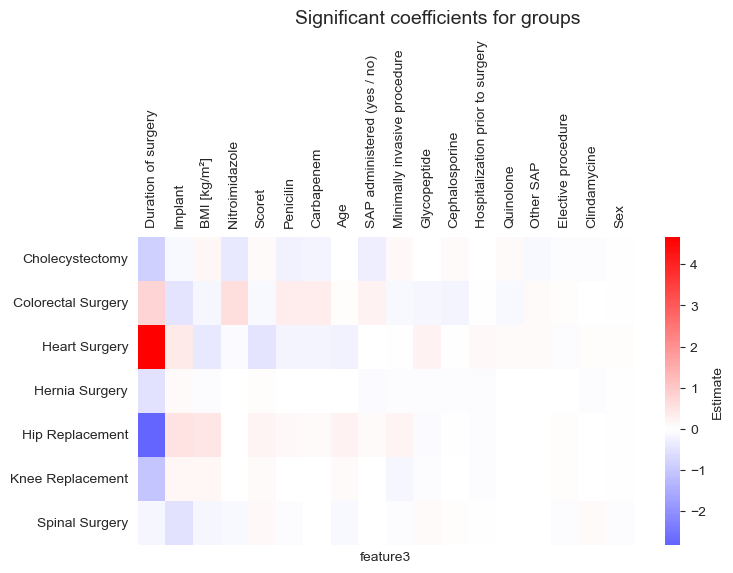

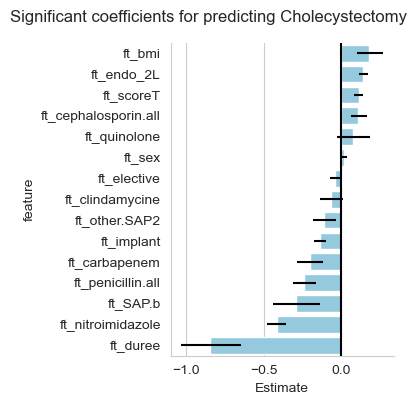

Ft_Surg_Colorectal Surgery


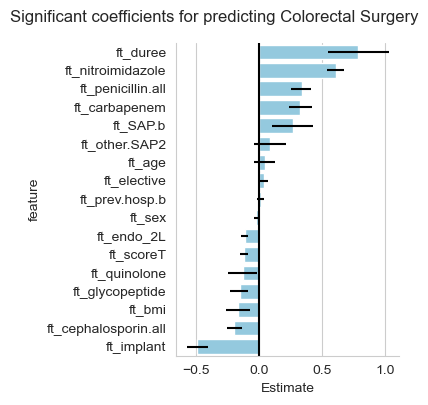

Ft_Surg_Heart Surgery


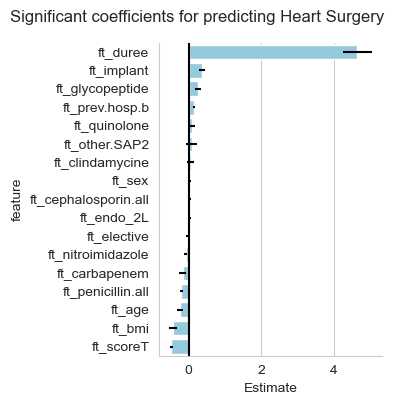

Ft_Surg_Hernia Surgery


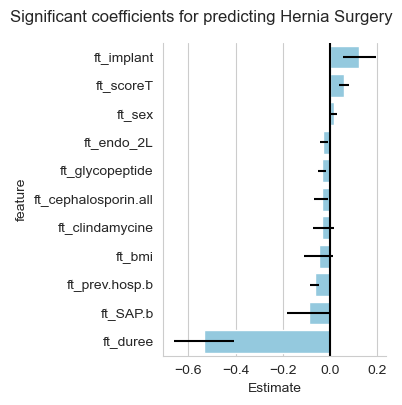

Ft_Surg_Hip Replacement


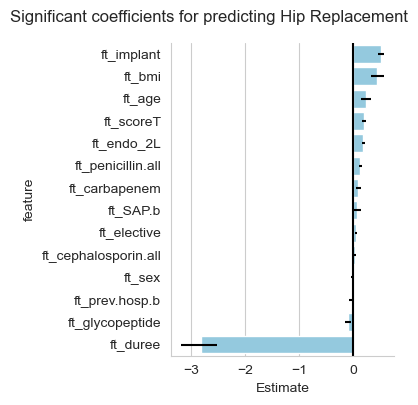

Ft_Surg_Knee Replacement


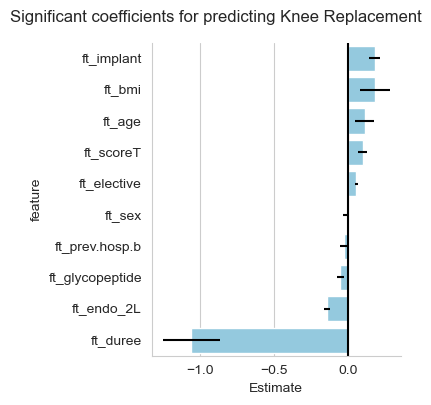

Ft_Surg_Spinal Surgery


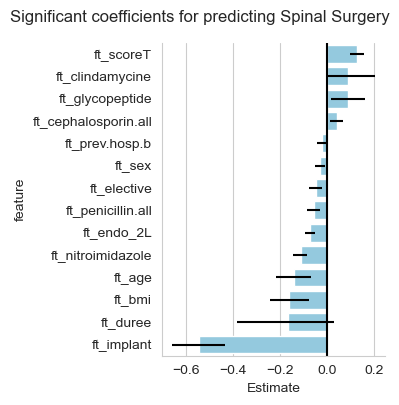

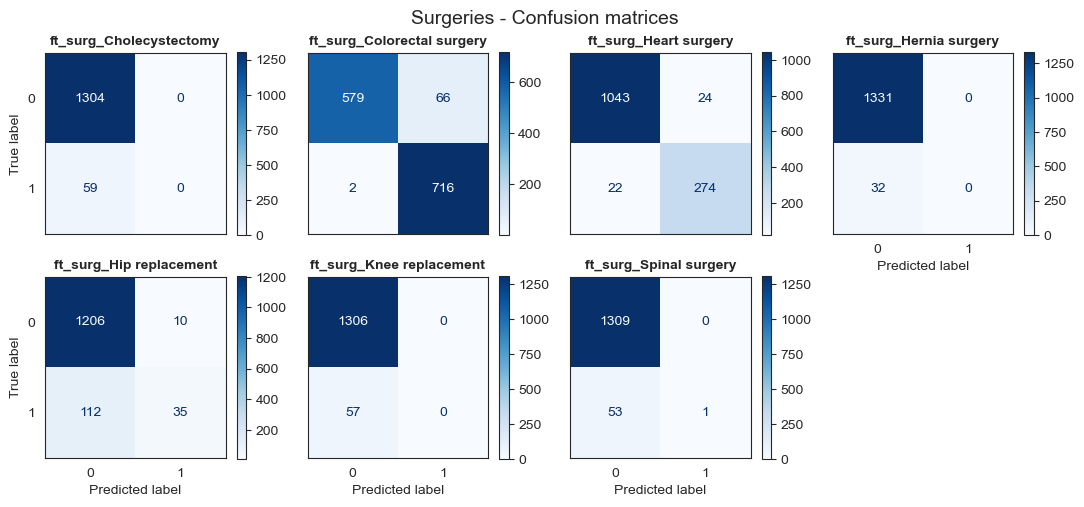

Done


In [34]:
dc = pd.read_csv('outputs_september/surgtype_coefficients.csv')#.sort_values(by='mean',ascending=False)
dd = dc[(dc['level']=='surg')&(dc['feature']!='_intercept')]
dd.loc[dd['p value']>0.05,'Estimate']=0
dd['Estimate'] = np.abs(dd['Estimate'])
P = pd.pivot(dd,index='name',columns='feature',values='Estimate').fillna(0)
p = P.sum(axis=0).to_frame().sort_values(by=0,ascending=False)
FINAL_COLUMNS = list(p.index)


coef_df = pd.read_csv('outputs_september/surgtype_coefficients.csv')
coef_df.loc[coef_df['hi']<coef_df['Estimate'],'hi'] = coef_df[coef_df['hi']<coef_df['Estimate']]['Estimate']
coef_df.loc[coef_df['lo']>coef_df['Estimate'],'lo'] = coef_df[coef_df['lo']>coef_df['Estimate']]['Estimate']

sns.set_style('whitegrid')
output_pdf = 'outputs_september/surgtype_coefficients.pdf'
pdf = PdfPages(output_pdf)

coef_df['feature2'] = pd.Categorical(coef_df['feature'],FINAL_COLUMNS)
coef_df.sort_values(by='feature2',inplace=True)

sns.set_style('white')

dx = coef_df[(coef_df['feature']!='_intercept')&(coef_df['p value']<=0.05)]
dx['feature'] = dx['feature'].apply(lambda x:map_all.get(x.replace('ft_',''),x.replace('ft_','').title()))
dx['feature3'] = dx['feature2'].apply(lambda x:map_all.get(x.replace('ft_',''),x.replace('ft_','').title()))

dd = dx[dx['level']=='surg']
dd['name'] = dd['name'].str.replace('Ft_Surg_','')
P = pd.pivot(dd,index='name',columns='feature3',values='Estimate')
P
fig,ax = plt.subplots(figsize=(8,4))
sns.heatmap(P, cmap='bwr', center=0, cbar_kws={'label': 'Estimate'},ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True,rotation=90)
ax.tick_params(axis='y', which='major', labelsize=10, labelleft=True,rotation=0)
ax.set_ylabel('')
plt.suptitle('Significant coefficients for groups',y=1.45,fontsize=14)
pdf.savefig(fig,bbox_inches='tight', pad_inches=.1)

sns.set_style('whitegrid')
coef_df.sort_values(by=['level','name','Estimate'],ascending=[True,True,False],inplace=True)
data = coef_df[coef_df['level']=='surg']
for name,data2 in data.groupby('name'):
    name = name.replace('ft_surg_','').title()
    print(name)
    data2 = data2[data2['p value']<=0.05].sort_values(by=['Estimate'],ascending=[False])
    # Calculate the errors
    data2['error_lower'] = data2['Estimate'] - data2['lo']
    data2['error_upper'] = data2['hi'] - data2['Estimate']    
    # Create asymmetric error values
    errors = [data2['error_lower'].values, data2['error_upper'].values]    
    
    g = sns.catplot(data=data2,
                    x='Estimate', y='feature', 
                    col='name',
                    col_wrap=1,
                    kind='bar',
                    aspect=1,                    
                    height=4,
                    xerr=errors,  # Adding error bars
                    capsize=5,color='skyblue')
    for ax in g.axes:
        ax.axvline(0, color='black', linewidth=1.5)  # Bold line at 0
    g.set_titles("")
    # g.axes[0].tick_params(labelsize=4)
    plt.suptitle('Significant coefficients for predicting %s'%name.replace('Ft_Surg_',''),y=1)
    pdf.savefig(g.fig,bbox_inches='tight', pad_inches=.1)
    plt.show()    

plot_confusion_matrices(y_test_surg,y_surg_pred,title='Surgeries - Confusion matrices',pdf=pdf,hue_order=None,hue_map=None)

pdf.close()
print('Done')